# Time Series Regression

# Abstract

This project aimed to build a time series regression model to predict future horizons using a provided dataset. The process involved conducting exploratory data analysis, feature engineering, and preprocessing. Both linear and non-linear time series forecasting models were explored, including Prophet (which has shown superior performance compared to other simple autoregressive models like SARIMA, ARIMA, and ARMA) and Neural Prophet (based on a feed-forward neural network architecture capable of capturing non-linear trend characteristics). Two variants of each of the Prophet and Neural Prophet model were developed, including a pre-tuned model and a hyperparameter-tuned model. The models used feature engineered regressor variables such as time-based variables (Day, Month, Year, and Quarter) and the provided exogenous variables (A1 and B1). Extensive cross-validation was conducted using the Mean Absolute Error, and the performance of the models (Baseline Prophet, Tuned Prophet Model, Pre-tuned Neural Prophet, and Hyperparameter-tuned Neural Prophet) were compared. Results showed that the Hyperparameter-tuned Neural Prophet model achieved the best performance. Additionally, the choice of MAE as the cross validation metric and the impact of the variable output length model was discussed, highlighting its flexibility advantage but added complexity compared to fixed horizon forecasts.

Keywords: Time Series Forecasting, Linear Model, Non-Linear Model, Prophet, Neural Prophet, Deep Learning

## Methodology

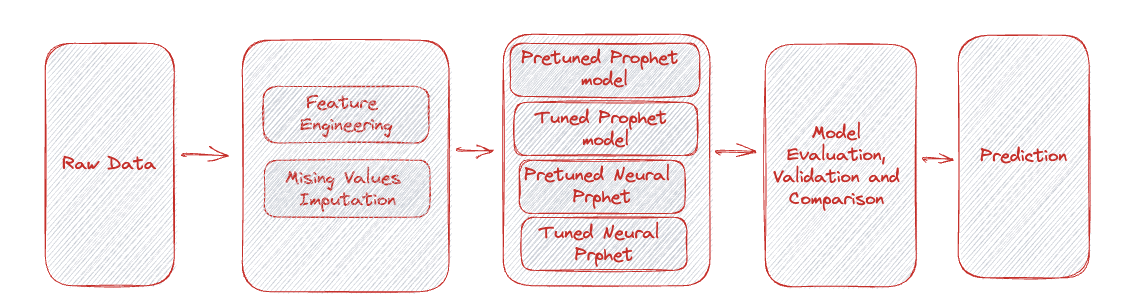

## Dev Environment and Import necessary packages

In [3]:
# cd neural_prophet 

In [2]:
from neuralprophet import NeuralProphet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import set_matplotlib_formats
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from typing import List, Dict

# set_matplotlib_formats("retina")
# %load_ext nb_black

In [ ]:
# cd /Users/oowola01/Library/Mobile Documents/com~apple~CloudDocs/OneDrive - Tufts/Apps/Job/Take Home/Kempstar/

## Load Data

In [ ]:
#load data
df = pd.read_csv("dataset1.csv")

## 1a. Exploratory Data Analysis 

In [ ]:
df.head()

In [ ]:
# check the data types and missing values
print(df.info())

In [ ]:
# describe the data
print(df.describe())

In [ ]:
# convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# set the date column as the index
df = df.set_index("date")

In [ ]:
# plot the time series data
plt.figure(figsize=(12,6))
plt.plot(df[["target"]])
plt.title('Plot of Time Series Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(["Target"])
plt.show()


In [ ]:
# plot the distribution of the data
plt.figure(figsize=(12, 6))
sns.distplot(df["target"])
plt.title("Distribution of Target")
plt.show()

In [ ]:
# plot the correlation matrix of the data
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# plot the pairplot of the data
plt.figure(figsize=(12, 6))
sns.pairplot(df)
plt.title("Pairplot")
plt.show()

In [ ]:
# plot the rolling mean and standard deviation of the target column
plt.figure(figsize=(12, 6))
plt.plot(df["target"].rolling(window=30).mean(), label="Rolling Mean")
plt.plot(df["target"].rolling(window=30).std(), label="Rolling Std")
plt.legend()
plt.title("Rolling Mean and Standard Deviation of Target")
plt.show()

In [ ]:
# plot the relationship between Target and the exogenous variables
plt.figure(figsize=(12, 6))
plt.plot(df["A1"], label="A1")
plt.plot(df["B1"], label="B1")
plt.plot(df["target"], label="Target")
plt.legend()
plt.title("Relationship Between Target and Exogenous Variables")
plt.show()

In [ ]:
df = df.asfreq(freq="W-FRI")

In [ ]:
df.head()

## Preprocessing and Feature Engineering

In [ ]:
# find null values in the reindexed data
df[~np.isfinite(df["target"])]

In [ ]:
# interpolate to fill missing values
df = df.interpolate()

In [ ]:
# plot the seasonal decomposition (seasonal decoposition can only be plotted after filling missing values)
result = seasonal_decompose(df['target'], model='multiplicative')

# plot the decomposed time series
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['target'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# plot the autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(nrows=2, figsize=(12, 8))
plot_acf(df[["target"]], ax=ax[0])
plot_pacf(df[["target"]], ax=ax[1])
plt.show()

In [ ]:
# view data
df.head()

In [ ]:
# rename columns for consistency
df = df.reset_index().rename(columns={"date": "ds", "target": "y"})

In [ ]:
# Create new features based on the date

# This function extracts the day of the month from a given date string
def is_day(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the day of the month from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.day


# This function extracts the quarter of the year from a given date string
def is_quarter(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the quarter of the year from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.quarter


# This function extracts the year from a given date string
def is_year(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the year from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.year


# This function extracts the month from a given date string
def is_month(ds):
    """
    :param ds: a date string in the format "yyyy-mm-dd"
    :type ds: str
    :return: the month from the given date string
    :rtype: int
    """
    date = pd.to_datetime(ds)
    return date.month


# This code applies each of the date functions to the "ds" column of the dataframe 'df', creating new columns for each feature
df["quarter"] = df["ds"].apply(is_quarter)
df["day"] = df["ds"].apply(is_day)
df["year"] = df["ds"].apply(is_year)
df["month"] = df["ds"].apply(is_month)

## 1b Model

In [ ]:
# modeified train test split function with additioonaparameters for columns to drop
def df_train_test_split(df, test_size=0.2, shuffle=False, cols_to_drop=[]):
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=shuffle)
    df_train = df_train.drop(columns=cols_to_drop)
    df_test = df_test.drop(columns=cols_to_drop)
    return df_train, df_test

### 1b (i) Baseline Linear Prophet Model

In [ ]:
# dropping A1 and B1 since their future values are unknown
df_train, df_test = df_train_test_split(
    df, test_size=0.2, shuffle=False, cols_to_drop=["A1", "B1"]
)

In [ ]:

class ProphetForecaster:
    """
    A class for creating and evaluating Prophet time series forecasting models.

    Parameters:
    -----------
    known_exog_vars: list
        A list of column names for known exogenous variables that should be used in the model.

    param_grid: dict or None, default=None
        A dictionary of hyperparameters to search over using GridSearchCV. 
        If None, the default hyperparameters of Prophet will be used.
    """

    def __init__(self, known_exog_vars, param_grid=None):
        self.known_exog_vars = known_exog_vars
        self.model = None
        self.param_grid = param_grid
        
    def predict(self, df):
        """
        Predicts future values for the given dataframe using the trained model.

        Parameters:
        -----------
        df: pandas DataFrame
            A dataframe containing the columns to use as inputs for the model.

        Returns:
        --------
        A pandas DataFrame containing the predicted values for each date in the input dataframe.
        """
        return self.model.predict(df)
    
    def evaluate(self, y_true, y_pred):
        """
        Calculates the Mean Absolute Error (MAE) between the true and predicted values.

        Parameters:
        -----------
        y_true: pandas Series
            The true values for the target variable.

        y_pred: pandas Series
            The predicted values for the target variable.

        Returns:
        --------
        The Mean Absolute Error between the true and predicted values.
        """
        return mean_absolute_error(y_true, y_pred)
    
    def make_future_dataframe(self, periods, freq):
        """
        Creates a future dataframe with the specified number of periods and frequency.

        Parameters:
        -----------
        periods: int
            The number of periods to forecast into the future.

        freq: str
            The frequency of the data, in Pandas date offset strings. 
            For example, 'D' for daily data, 'W' for weekly data, 'M' for monthly data, etc.

        Returns:
        --------
        A Pandas DataFrame with a datetime index and the specified number of future periods.
        """
        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        future["quarter"] = future["ds"].apply(is_quarter)
        future["day"] = future["ds"].apply(is_day)
        future["year"] = future["ds"].apply(is_year)
        future["month"] = future["ds"].apply(is_month)
        return future
    
    def fit(self, df_train, model):
        """
        Fits the model to the training data using the known exogenous variables.

        Parameters:
        -----------
        df_train: pandas DataFrame
            A dataframe containing the columns to use as inputs for the model and the target variable.

        model: Prophet
            An instance of the Prophet class with hyperparameters set. 
            This model will be trained on the input training data.
        """
        self.model = model
        for i in self.known_exog_vars:
            self.model.add_regressor(name=i)
        self.model.fit(df_train)
    
    def plot_forecast(self, forecast):
        """
        Plots the forecasted values.

        Parameters:
        -----------
        forecast: pandas DataFrame
            A dataframe containing the forecasted values.
        """
        self.model.plot(forecast);
    
    def plot_component(self, forecast):
        """
        Plots the trend, seasonality, and holiday components of the forecast.

        Parameters:
        -----------
        forecast: pandas DataFrame
            A dataframe containing the forecasted values
        """
        self.model.plot_components(forecast);


In [ ]:
# create an instance of the ProphetModel class
model = ProphetForecaster(
    known_exog_vars=["day", "month", "year", "quarter"],
)

# train the model on the training set
model.fit(df_train,  model=Prophet())

# make predictions on the testing set
test_forecast = model.predict(df_test)

# evaluate the model on the testing set using MAE
mae_pretuned_prp = model.evaluate(df_test["y"], test_forecast["yhat"])

# fit the model on the entire data
model.fit(df, model=Prophet())

# make predictions on future data
future = model.make_future_dataframe(periods=3, freq="W-FRI")
forecast = model.predict(future)


In [ ]:
# plot the forecast
model.plot_forecast(forecast)

In [ ]:
# plot the forecast components
model.plot_component(forecast)

In [ ]:
test_forecast.head()

In [ ]:
# view predictions
forecast.tail(4)

### 1b (i) Hyperparameter Tuned Linear Prophet Model

In [ ]:
class ProphetGridSearch:
    def __init__(self, known_exog_vars: List[str], param_grid: Dict[str, List]):
        """
        Initialize ProphetGridSearch class with the given parameters.

        :param known_exog_vars: List of known exogenous variables to use in the Prophet model.
        :param param_grid: Dictionary of hyperparameters and their possible values to be tuned.
        """
        self.best_model = None
        self.best_mae = float("inf")
        self.best_param = None
        self.known_exog_vars = known_exog_vars
        self.param_grid = param_grid

    def gridsearch(self, df_train: pd.DataFrame, df_test: pd.DataFrame):
        """
        Grid search over all combinations of hyperparameters and select the best Prophet model based on MAE.

        :param df_train: Training dataframe.
        :param df_test: Testing dataframe.
        """
        # Loop over all combinations of hyperparameters
        for params in ParameterGrid(self.param_grid):

            # Initialize a ProphetForecaster object
            m = ProphetForecaster(known_exog_vars=self.known_exog_vars)

            # Train the model on the training set
            m.fit(df_train, model=Prophet(**params))

            # Make predictions on the testing set
            test_forecast = m.predict(df_test)

            # Evaluate the model on the testing set using MAE
            mae = m.evaluate(df_test["y"], test_forecast["yhat"])

            # Update the best model if the current model has a lower MAE
            if mae < self.best_mae:
                self.best_mae = mae
                self.best_model = m
                self.best_param = params

        print("Best Hyperparameters:", self.best_param)
        print("Best MAE:", self.best_mae)

In [ ]:
# Define the parameter grid to search over
param_grid = {
    "seasonality_mode": ["multiplicative", "additive"],
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5, 1],
    "seasonality_prior_scale": [0.01, 0.1, 1, 10],
    "changepoint_range": [0.9, 0.95],
    "yearly_seasonality": [True,],
}

In [ ]:
# Create an instance of the ProphetGridSearch class with the specified known exogenous variables and parameter grid
grid_cv = ProphetGridSearch(
    known_exog_vars=["day", "month", "year", "quarter"], param_grid=param_grid
)

# Perform a grid search over the hyperparameter space using the training and testing sets
grid_cv.gridsearch(df_train, df_test)

# Get the best hyperparameters and corresponding MAE from the grid search
tuned_prp_best_param = grid_cv.best_param
best_mae_tuned_prp = grid_cv.best_mae

In [ ]:
# create an instance of the ProphetModel class
model = ProphetForecaster(
    known_exog_vars=["day", "month", "year", "quarter"]
)

# fit the model on the entire data
model.fit(df, model=Prophet(**tuned_prp_best_param))

# make predictions on future data
future = model.make_future_dataframe(periods=3, freq="W-FRI")
forecast = model.predict(future)


In [ ]:
# plot the forecast
model.plot_forecast(forecast)

In [ ]:
# plot forecast component
model.plot_component(forecast)

### 1b (i) Pretuned Non-Linear Neural Prophet Model

In [ ]:
# leaving A1 and B1 since NP model can handle cases where future values are unknown
df_train, df_test = df_train_test_split(
    df, test_size=0.2, shuffle=False, cols_to_drop=[]
)

In [ ]:
class NeuralProphetForecaster:
    def __init__(self, known_exog_vars, param_grid=None):
        """
        Initialize the NeuralProphetForecaster.

        Parameters:
        known_exog_vars (list): list of column names of known exogenous variables
        param_grid (dict): dictionary of hyperparameters to be tuned (default=None)
        """
        self.known_exog_vars = known_exog_vars
        self.model = None
        self.param_grid = param_grid
        self.metrics = None
        
    def predict(self, df):
        """
        Generate predictions for the input dataframe.

        Parameters:
        df (pandas.DataFrame): dataframe containing time series data to make predictions for

        Returns:
        pandas.DataFrame: dataframe containing predictions
        """
        return self.model.predict(df)
    
    def evaluate(self):
        """
        Evaluate the model's performance on the validation set.

        Returns:
        float: minimum mean absolute error (MAE) on the validation set
        """
        return self.metrics["MAE_val"].min()
    
    def make_future_dataframe(self, df):
        """
        Create a future dataframe to make predictions.

        Parameters:
        df (pandas.DataFrame): dataframe containing time series data

        Returns:
        pandas.DataFrame: future dataframe
        """
        future = self.model.make_future_dataframe(df, n_historic_predictions=len(df))
        future["quarter"] = future["ds"].apply(is_quarter)
        future["day"] = future["ds"].apply(is_day)
        future["year"] = future["ds"].apply(is_year)
        future["month"] = future["ds"].apply(is_month)
        return future
    
    def fit(self, df_train, df_test, model):
        """
        Fit the NeuralProphet model.

        Parameters:
        df_train (pandas.DataFrame): dataframe containing time series training data
        df_test (pandas.DataFrame): dataframe containing time series validation data
        model (NeuralProphet): NeuralProphet model object
        """
        self.model = model
        self.model.add_lagged_regressor(names=self.known_exog_vars)
        self.metrics = self.model.fit(df=df_train, freq="W-FRI", validation_df=df_test, progress="plot")
        
    def plot_forecast(self, forecast):
        """
        Plot the forecast generated by the model.

        Parameters:
        forecast (pandas.DataFrame): dataframe containing forecast data
        """
        self.model.plot(forecast)
    
    def plot_component(self):
        """
        Plot the trained model's parameter components.
        """
        return self.model.plot_parameters()


In [ ]:
# Define the exogenous variables
exog_vars = ["A1", "B1", "day", "month", "year", "quarter"]

# create an instance of the NeuralProphetModel class
model = NeuralProphetForecaster(
    known_exog_vars=exog_vars,
)

# train the model on the training set
metrics = model.fit(df_train, df_test,  model=NeuralProphet(
    n_forecasts=3,
))


# evaluate the model on the testing set using MAE
mae_pretuned_np = model.evaluate()


# make predictions on future data
future = model.make_future_dataframe(df)
forecast = model.predict(future)


In [ ]:
model.plot_component()

### 1b (ii) Hyperparameter Tuned Neural Prophet Model

In [ ]:
class NeuralProphetGridSearch:
    def __init__(self, known_exog_vars, param_grid):
        """
        Constructor for NeuralProphetGridSearch class.

        Parameters:
            known_exog_vars (list of str): List of names of known exogenous variables.
            param_grid (dict): Dictionary containing hyperparameters to search over.
        """
        self.best_model = None
        self.best_mae = float("inf")
        self.best_param = None
        self.known_exog_vars = known_exog_vars
        self.param_grid = param_grid

    def gridsearch(self, df_train, df_test):
        """
        Perform grid search over hyperparameters to find the best NeuralProphet model.

        Parameters:
            df_train (pandas DataFrame): Training data.
            df_test (pandas DataFrame): Testing data.
        """
        # Loop over all combinations of hyperparameters
        for params in ParameterGrid(self.param_grid):

            # create an instance of the NeuralProphetModel class
            model = NeuralProphetForecaster(known_exog_vars=self.known_exog_vars)

            # train the model on the training set
            metrics = model.fit(df_train, df_test, model=NeuralProphet(**params))

            # evaluate the model on the testing set using MAE
            mae = model.evaluate()

            # Update the best model if the current model has a lower MAE
            if mae < self.best_mae:
                self.best_mae = mae
                self.best_model = model
                self.best_param = params
        # Print the best hyperparameters and MAE
        print("Best Hyperparameters:", self.best_param)
        print("Best MAE:", self.best_mae)


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "num_hidden_layers": [1, 2],
    "d_hidden": [4, 8],
    "learning_rate": [0.01, 0.1],
    "yearly_seasonality": [True],
    "n_lags": [3],
    "changepoints_range": [0.95],
    "n_lags": [3],
    "n_forecasts":[3]
}


In [ ]:
grid_cv = NeuralProphetGridSearch(
    known_exog_vars=["A1", "B1", "day", "month", "year", "quarter"],
    param_grid=param_grid,
)
grid_cv.gridsearch(df_train, df_test)
tuned_np_best_param = grid_cv.best_param
best_mae_tuned_np = grid_cv.best_mae
best_model_tuned_np = grid_cv.best_model

In [ ]:
# Define the exogenous variables
exog_vars = ["A1", "B1", "day", "month", "year", "quarter"]

# create an instance of the NeuralProphetModel class
model = NeuralProphetForecaster(
    known_exog_vars=exog_vars,
)

# train the model on the training set
metrics = model.fit(df_train, df_test,  model=NeuralProphet(**tuned_np_best_param
))

# evaluate the model on the testing set using MAE
mae_tuned_np = model.evaluate()


# make predictions on future data
future = model.make_future_dataframe(df)
forecast = model.predict(future)


In [ ]:
# plot component
model.plot_component()

In [ ]:
# view last 5 forecast
forecast.tail(5)

### 1b (ii) Comparison

In [ ]:
##bar plot of MAEs

In [ ]:
def score_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    scores = {
        "Pretuned Prophet": mae_pretuned_prp,
        "Tuned Prophet": best_mae_tuned_prp,
        "Pretuned Neural Prophet": mae_pretuned_np,
        "Tuned Neural Prophet": best_mae_tuned_np,
    }

    ax.set_title("Score Plot")
    ax.bar(scores.keys(), scores.values())
    ax.margins(y=0.1)
    plt.ylabel("Mean Absolute Error")
    plt.show()


score_plot()

## 1c. Discussion of Metric Choice

In summary, MAE is a good choice for this time series forecasting work because it is intuitive, robust to outliers, scale-independent. It measures the average absolute difference between the predicted and actual values. There are several reasons why MAE is a good choice for this time series forecasting problem:

1. MAE is intuitive and easy to understand: The MAE is simply the average of the absolute differences between the predicted and actual values. This makes it easy to interpret and communicate the accuracy of the model to stakeholders.

2. MAE is robust to outliers: MAE is less sensitive to outliers than other metrics such as mean squared error (MSE), which squares the errors before averaging them. This means that a few large errors won't have as much impact on the overall metric as they would with MSE.

3. MAE is scale-independent: MAE is measured in the same units as the forecast variable, making it easy to compare across different time series or forecasting models. This is not the case for other metrics such as percentage errors, which are dependent on the scale of the data.

## Bonus: Pros and Cons of Variable Length Horizon

Pros:
Flexibility - A variable output length model provides more flexibility in terms of the forecasting horizon. This means that the model can be used to generate forecasts for a range of time horizons, without needing to retrain the model or change any hyperparameters.

Cons:
Complexity -  A model with a variable output length can be more complex than a model with a fixed output length. This is because the model needs to be able to generate forecasts for different lengths of time horizons, which can make the model architecture more complicated and increase the time complexity.


## Summary

This time series forecasting work evaluated two classes of models: the linear model (Prophet) and the non-linear model (Neural Prophet based on a deep learning architecture). Both tuned and pre-tuned variants of each model were examined, resulting in four models for forecasting the target variable over the next three horizons. The results indicated that the Tuned Neural Prophet model produced the lowest Mean Square Error, suggesting that it better captured the non-linear trends in the data.

## Future Work

Despite the promising results obtained from this work, there are still opportunities for future work. One direction for future work would be to explore the use of other time series regression models like LSTM, GRU, and ConvLSTM, which are known for their ability to capture long-term dependencies and nonlinear patterns in time series data. Additionally, incorporating more exogenous variables or alternative feature engineering techniques, such as time-series cross-validation, may improve the model's performance. Finally, testing the models on larger and more diverse datasets with varying time-series characteristics could also provide more insights into the robustness and generalizability of the models developed in this work.